## YOLO


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copiamos los datos al entorno de Colab
!mkdir -p /content/data
%cd /content/data
!cp /content/drive/MyDrive/image_processing/tarea2/orand-car-with-bbs.zip .
!unzip -q -o orand-car-with-bbs.zip
!rm orand-car-with-bbs.zip

/content/data


## YOLOv5

La implementación de este modelo se puede encontrar en el siguiente repositorio: https://github.com/ultralytics/yolov5 (para más información, ir [aquí](https://towardsai.net/p/computer-vision/yolo-v5%E2%80%8A-%E2%80%8Aexplained-and-demystified)). Para llevar a cabo el entrenamiento sobre un dataset personalizado, pueden seguir este tutorial: https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data. Los pasos más relevantes son crear un archivo de configuración que contenga la ruta de las imágenes, la cantidad de clases y los nombres de las categorías. Además, debemos convertir las coordenadas de las anotaciones desde el formato [class_idx, xmin, ymin, width, height] que viene con el dataset a un formato [class_idx, x_center, y_center, width, height], donde las coordenadas están normalizadas por el tamaño de la imagen. El resto del proceso se puede llevar a cabo tal como se indica en el tutorial y en el README del repositorio. Para modificar los parámetros de detección, pueden revisar los argumentos del archivo *detect.py* (incluye la opción de NMS).

### Convertir coordenadas

El primer paso será convertir el formato de las anotaciones como se mencionó anteriormente. El código requiere tener las imágenes en un directorio llamado 'images' y las anotaciones en un directorio llamado 'labels'.


In [3]:
%cd /content/data/orand-car-with-bbs/training
!mkdir labels

import cv2
import glob
import os

filenames = glob.glob("./annotations/*.txt")

# Iteramos sobre todas las imágenes
for filename in filenames:

    # Abrimos la imagen para obtener sus dimensiones
    img_path = filename.split("/")[-1].replace(".txt", ".png")
    img_path = os.path.join("./images", img_path)
    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape

    # Obtenemos las coordenadas de cada objeto en la imagen
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        lines = [x.replace(' ', '') for x in lines]

    annotations_yolo = []
    # Iteramos sobre todas las anotaciones de la imagen
    for obj in lines:
        label = obj.split(":")[0]
        bbox = obj.split(":")[1]
        bbox = bbox.replace(",", " ")

        annotation = label + " " + bbox
        ann = annotation.split(" ")
        ann = [int(x) for x in ann]
        label = ann[0]
        xmin, ymin, width, height = ann[1:]

        # Obtenemos las coordenadas normalizadas
        x_center = (xmin + (width / 2)) / img_width
        y_center = (ymin + (height/ 2)) / img_height
        width = width / img_width
        height = height / img_height

        obj_info = [label, x_center, y_center, width, height]
        annotations_yolo.append(obj_info)

    # Escribimos las nuevas anotaciones en un archivo del mismo nombre pero 
    # en el directorio labels
    new_filename = filename.split("/")[-1]
    new_filename = os.path.join("./labels", new_filename)
    with open(new_filename, mode='w') as outfile:
        for annotation in annotations_yolo:
            annotation = [str(x) for x in annotation]
            line = ' '.join(annotation)
            outfile.write("%s\n" % line)

/content/data/orand-car-with-bbs/training


In [4]:
# Ejemplo de anotación antigua
!cat /content/data/orand-car-with-bbs/training/annotations/0001_5179655_46066.txt

4: 83, 8, 43, 53
6: 143, 11, 39, 50
0: 204, 11, 43, 43
6: 264, 15, 43, 43
6: 329, 11, 36, 51

In [5]:
# Ejemplo de la misma anotación pero con el nuevo formato
!cat /content/data/orand-car-with-bbs/training/labels/0001_5179655_46066.txt

4 0.2301762114537445 0.4928571428571429 0.0947136563876652 0.7571428571428571
6 0.3579295154185022 0.5142857142857142 0.08590308370044053 0.7142857142857143
0 0.4966960352422907 0.4642857142857143 0.0947136563876652 0.6142857142857143
6 0.6288546255506607 0.5214285714285715 0.0947136563876652 0.6142857142857143
6 0.76431718061674 0.5214285714285715 0.07929515418502203 0.7285714285714285


Ahora dividiremos los datos en un conjunto de entrenamiento y uno de test, en una proporción 90%-10% respectivamente.

In [6]:
%cd /content/data/orand-car-with-bbs/training

import numpy as np
import random

filenames = glob.glob("images/*.png")
random.shuffle(filenames)

n = len(filenames)
split_ratio = 0.9
split_index = np.rint(n * split_ratio).astype("int")

train_split = filenames[:split_index]
test_split = filenames[split_index:]

train_dir = "/content/data/orand-car-with-bbs/training/"

with open("train.txt", mode='w') as outfile:
    for annotation in train_split:
        annotation = os.path.join(train_dir, annotation)
        outfile.write("%s\n" % annotation)

with open("test.txt", mode='w') as outfile:
    for annotation in test_split:
        annotation = os.path.join(train_dir, annotation)
        outfile.write("%s\n" % annotation)

print(f"Total de imágenes: {n}")
print(f"Imágenes de entrenamiento: {len(train_split)}")
print(f"Imágenes de test: {len(test_split)}")

/content/data/orand-car-with-bbs/training
Total de imágenes: 6506
Imágenes de entrenamiento: 5855
Imágenes de test: 651


### Entrenamiento

Para el entrenamiento seguiremos los siguientes pasos:

* Clonar el repositorio de YOLOv5.
* Instalar las librerías requeridas.
* Modificar los archivos de configuración necesarios.

In [7]:
# Clonamos el repositorio
%cd /content
!rm -rf yolov5
!git clone https://github.com/alvaro-neira/yolov5.git

# Instalamos los requisitos
%cd /content/yolov5
!git fetch --all
!git checkout tarea2
!pip install -r requirements.txt

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 10013, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10013 (delta 0), reused 4 (delta 0), pack-reused 10008
Receiving objects: 100% (10013/10013), 10.31 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (6945/6945), done.
/content/yolov5
Fetching origin
Branch 'tarea2' set up to track remote branch 'tarea2' from 'origin'.
Switched to a new branch 'tarea2'
     |████████████████████████████████| 596 kB 2.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Entrenamos el modelo ~22 minutos
%cd /content/yolov5
!python train.py --img 640 --batch 16 --epochs 10 --data digits.yaml --weights yolov5s.pt

In [ ]:
!cp -r /content/yolov5/runs/train /content/drive/MyDrive/image_processing/tarea2/runs

### Testing

In [ ]:
%cd /content/yolov5
!python detect.py --source /content/data/orand-car-with-bbs/test/images --weights runs/train/exp/weights/best.pt --conf 0.25 --save-txt

/content/yolov5
detect: weights=['runs/train/exp/weights/best.pt'], source=/content/data/orand-car-with-bbs/test/images, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-104-gd1a00a3 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7037095 parameters, 0 gradients, 15.9 GFLOPs
image 1/463 /content/data/orand-car-with-bbs/test/images/handwritten_MX8900201925091235157_oQ4HtfShcU-BqOSjyAJ6Zg.bmp: 192x640 3 0s, 1 6, 1 8, Done. (0.010s)
image 2/463 /content/data/orand-car-with-bbs/test/images/handwritten_MX8900201925091339247_k7Mofitc_EuA-kzxGZSyfQ.bmp: 128x640 4 0s, 1 2, 1 3, 1 4, Done. (0.010s)
image 3/463 /content/data

In [ ]:
!mkdir -p /content/drive/MyDrive/image_processing/tarea2/testing2

In [ ]:
!cp -r /content/yolov5/runs/detect /content/drive/MyDrive/image_processing/tarea2/testing2/runs

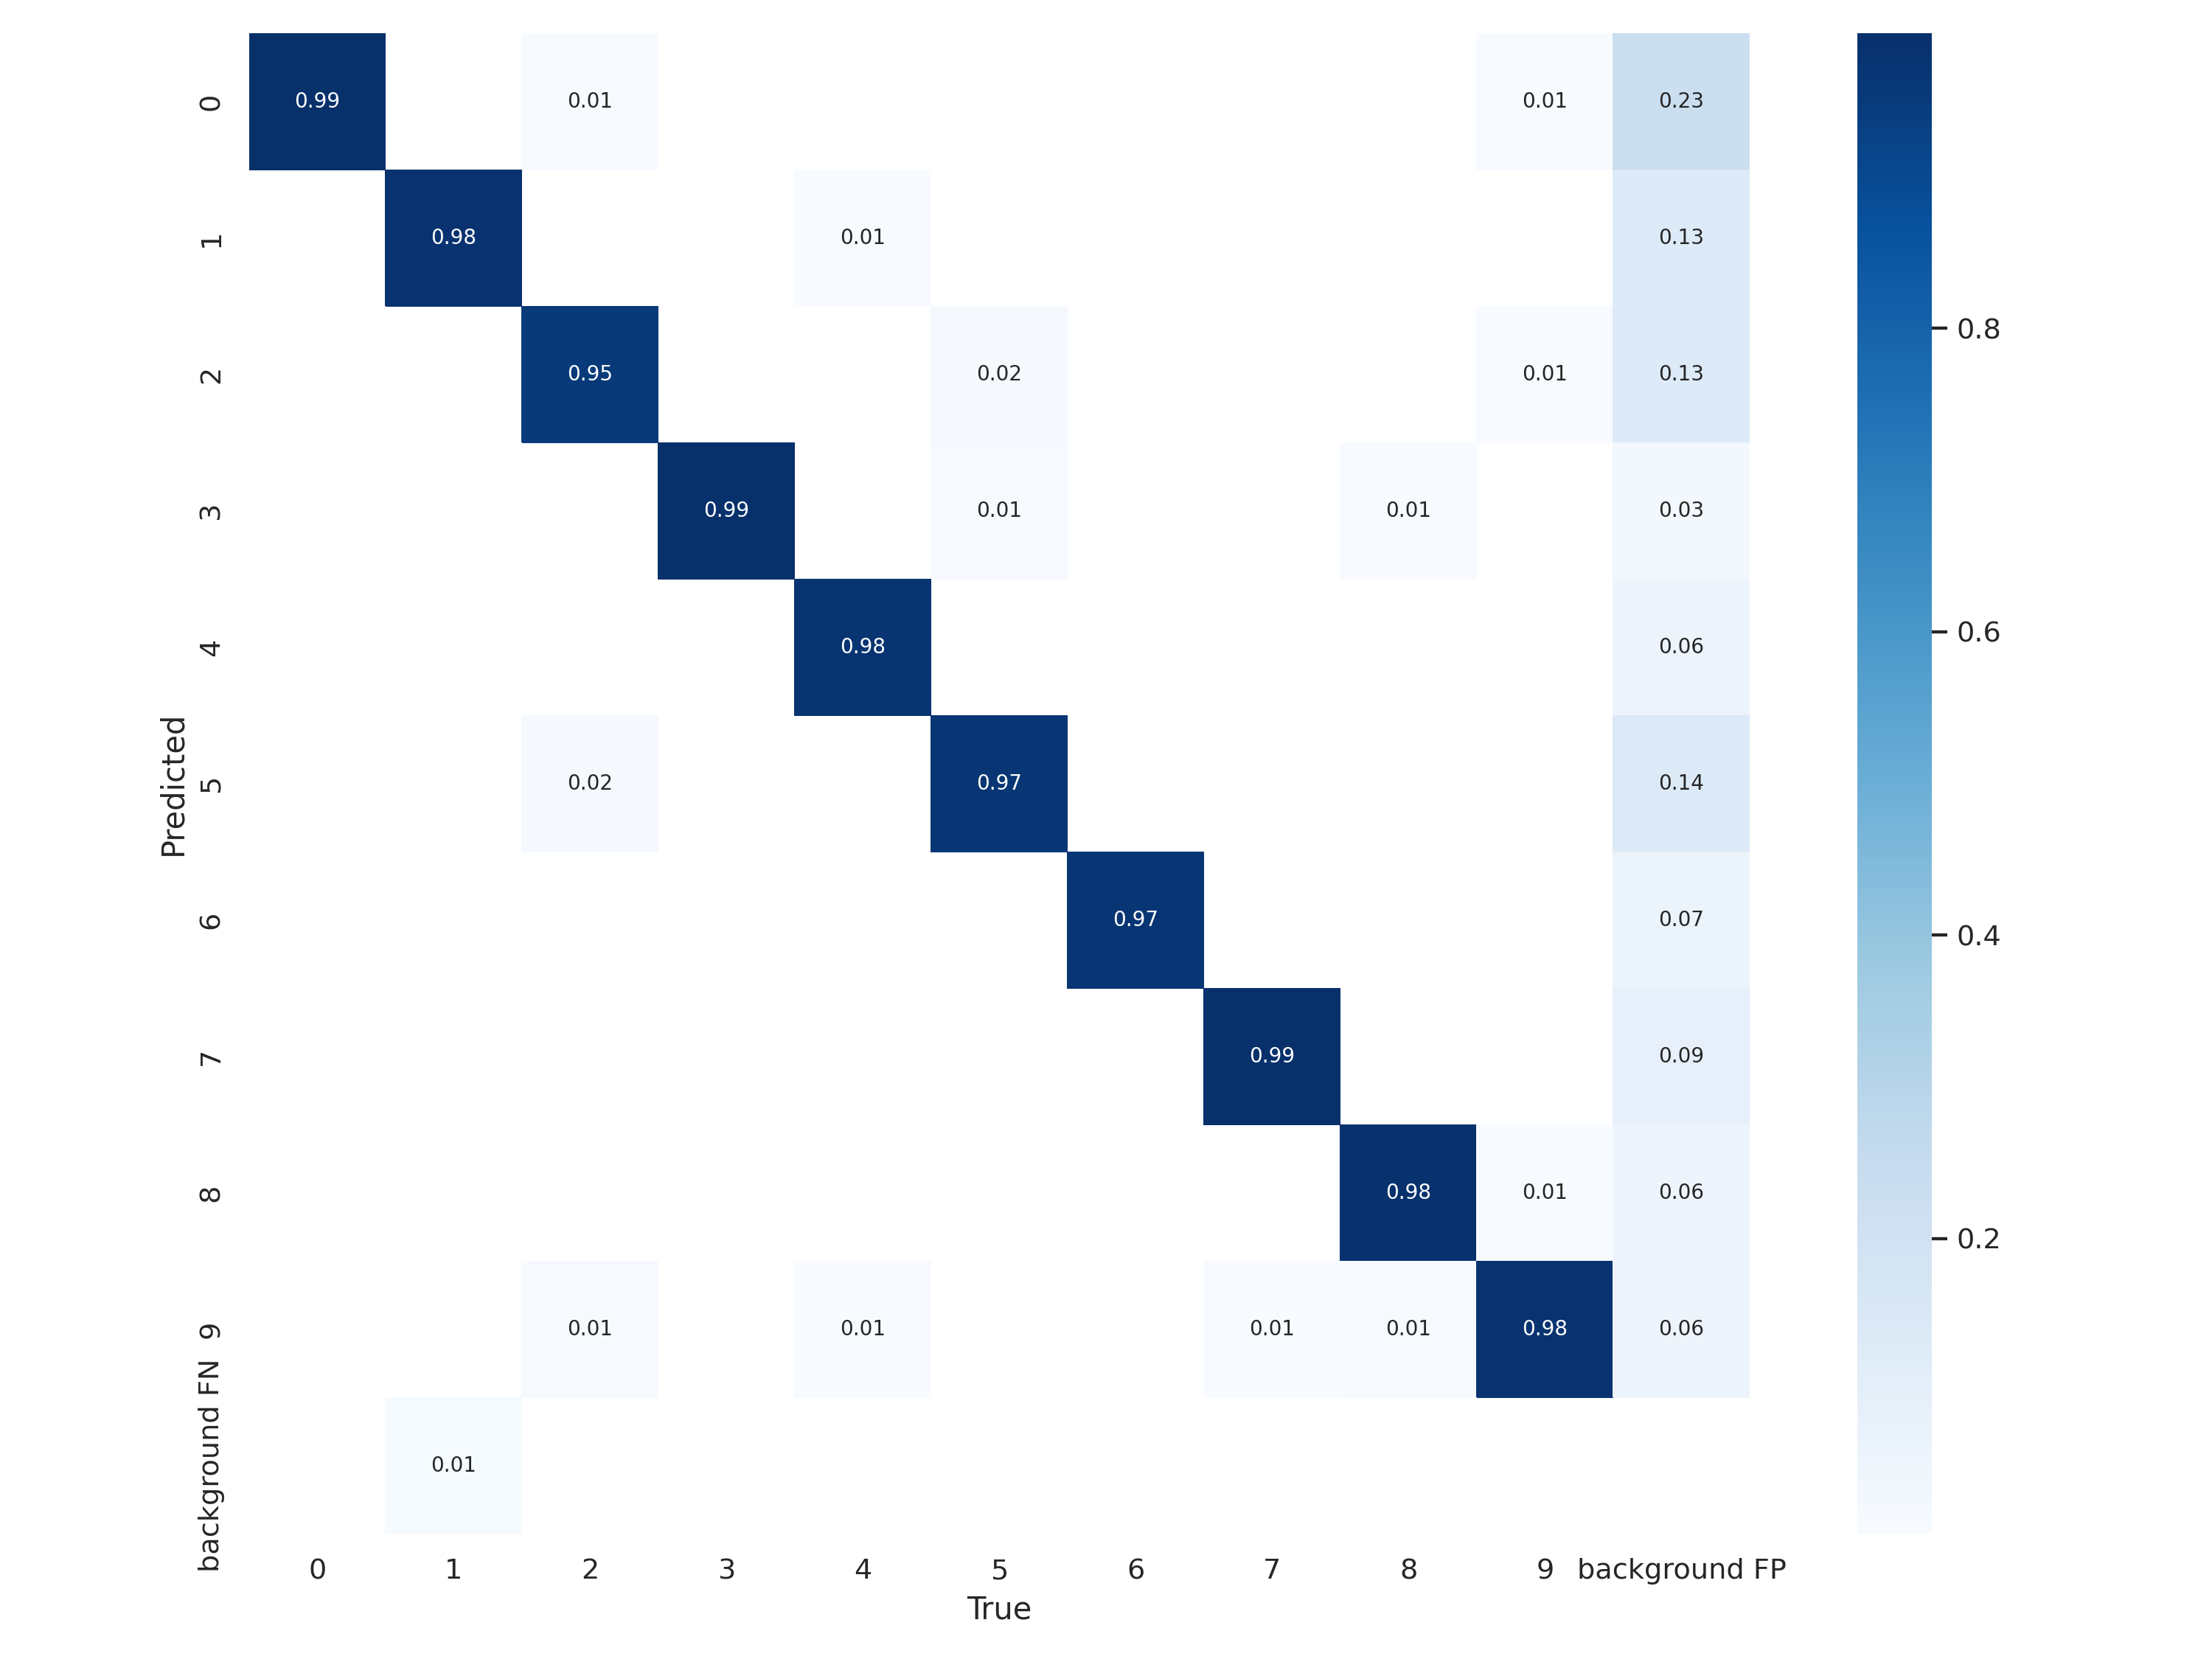

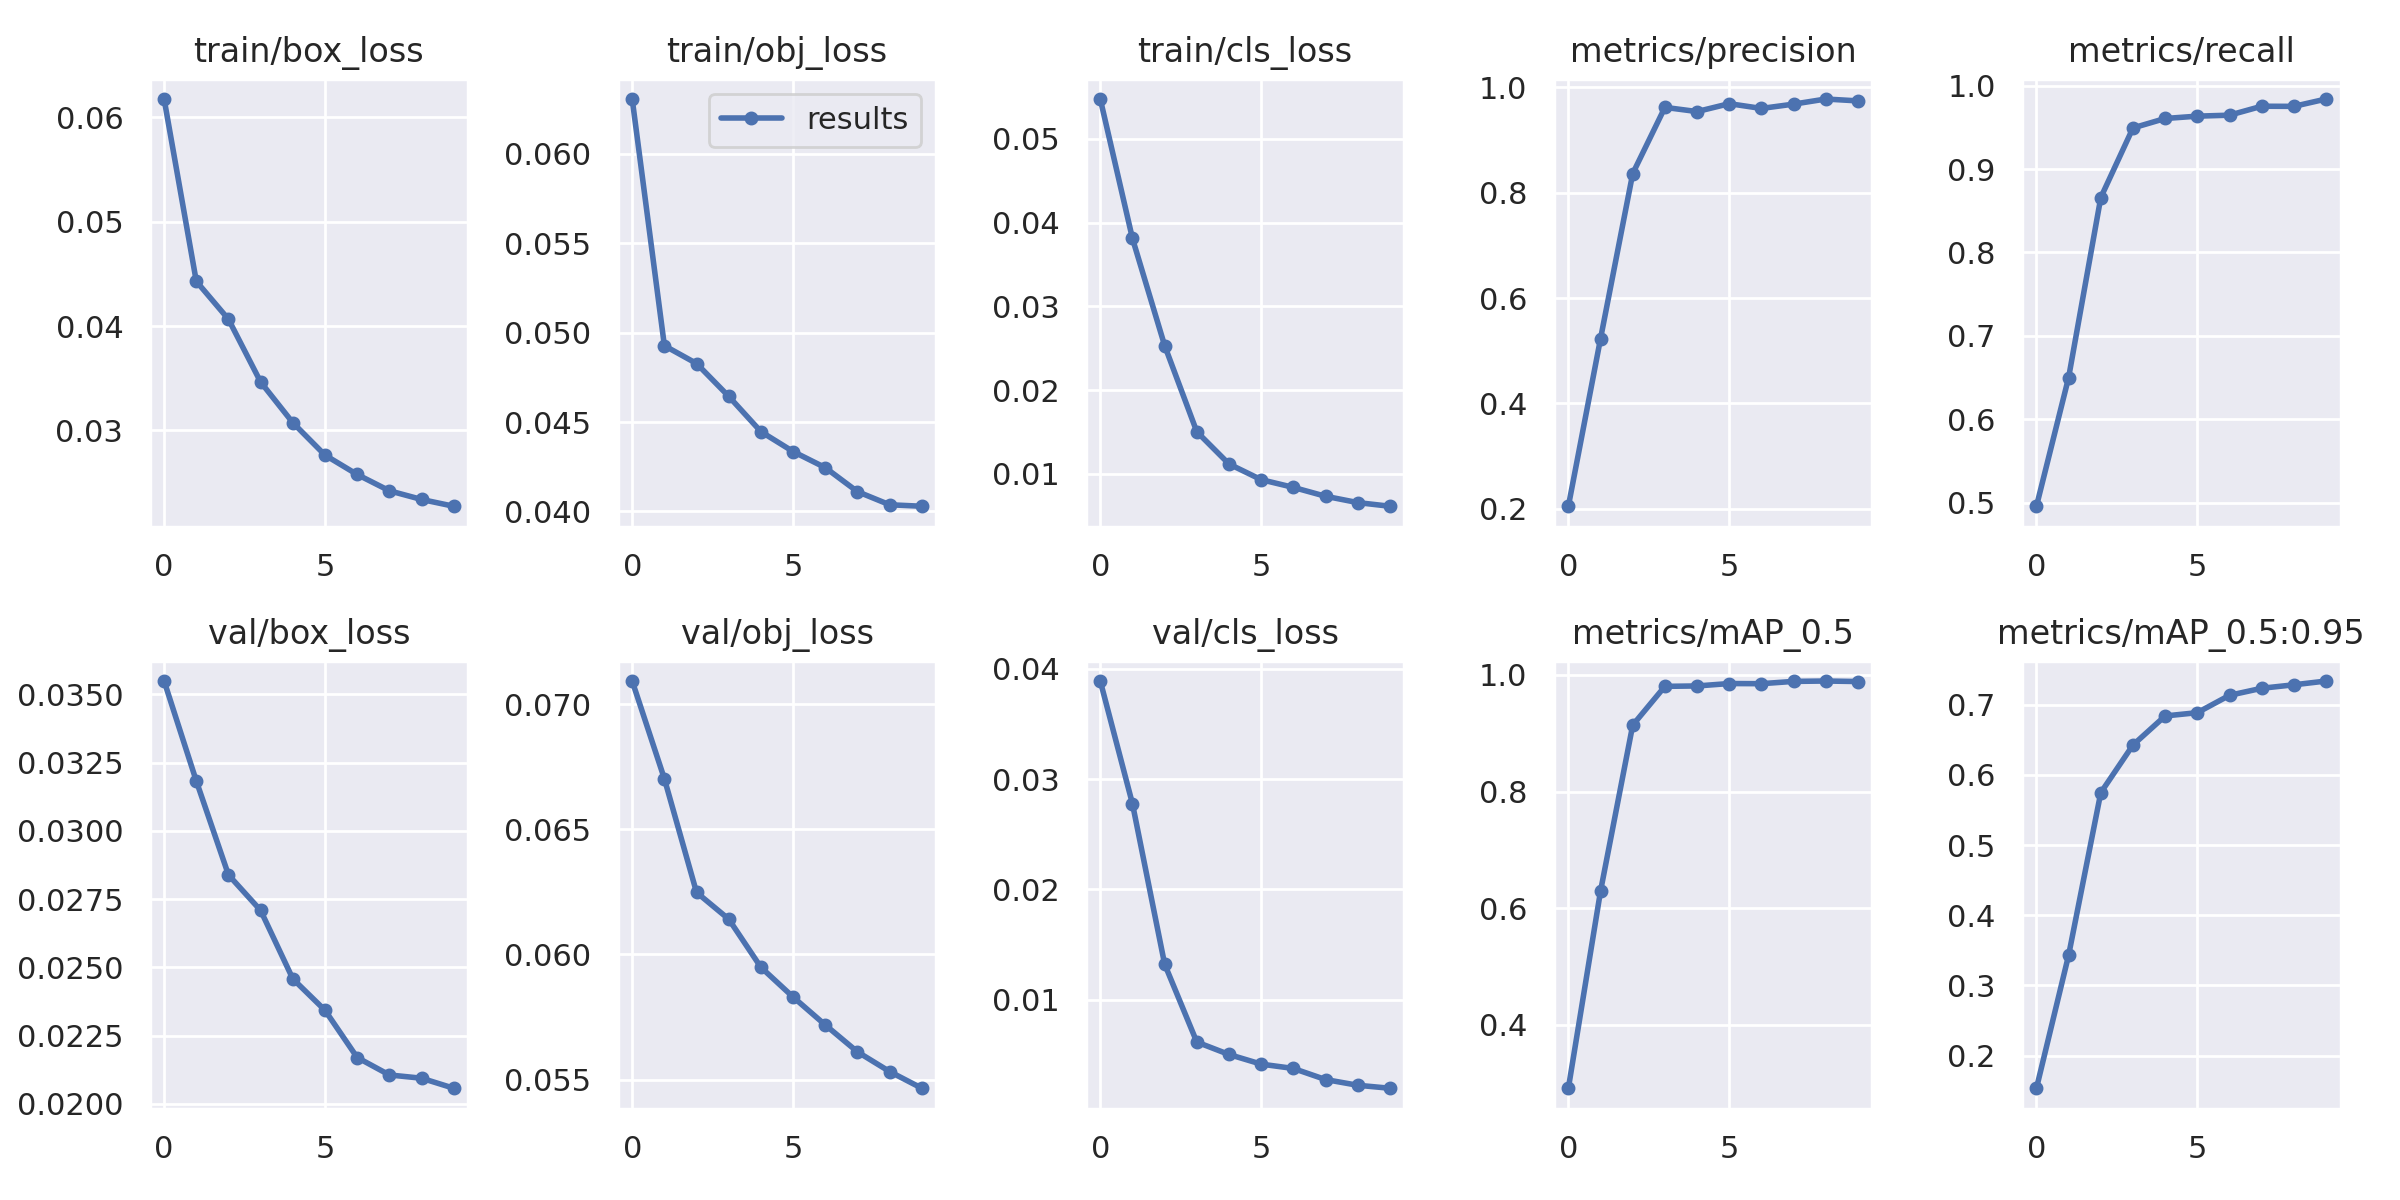

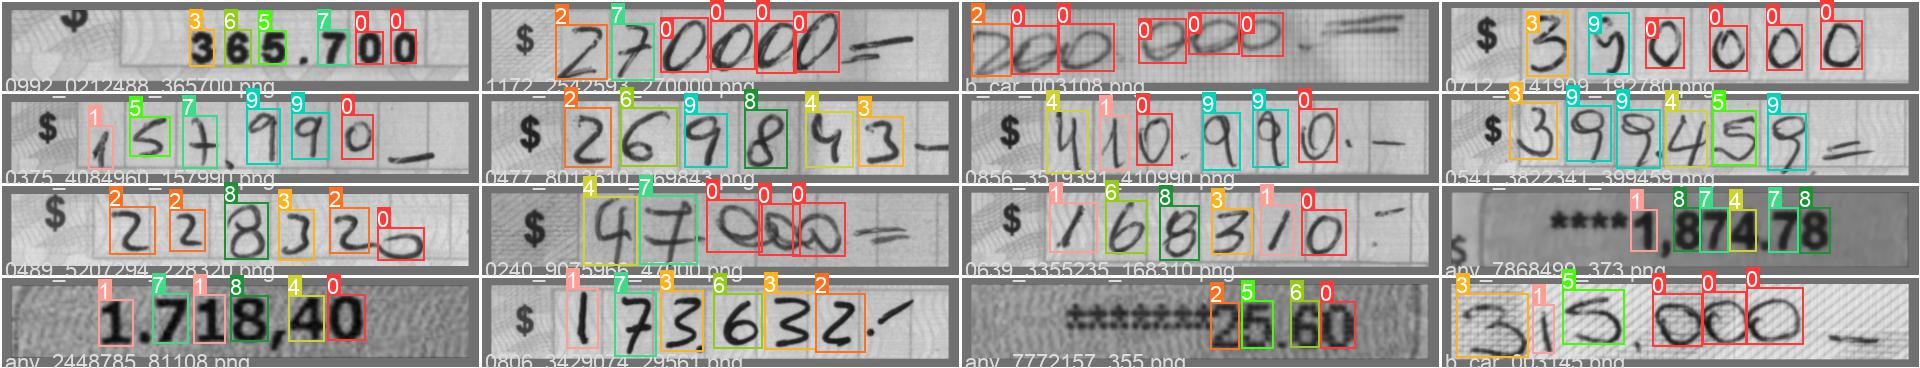

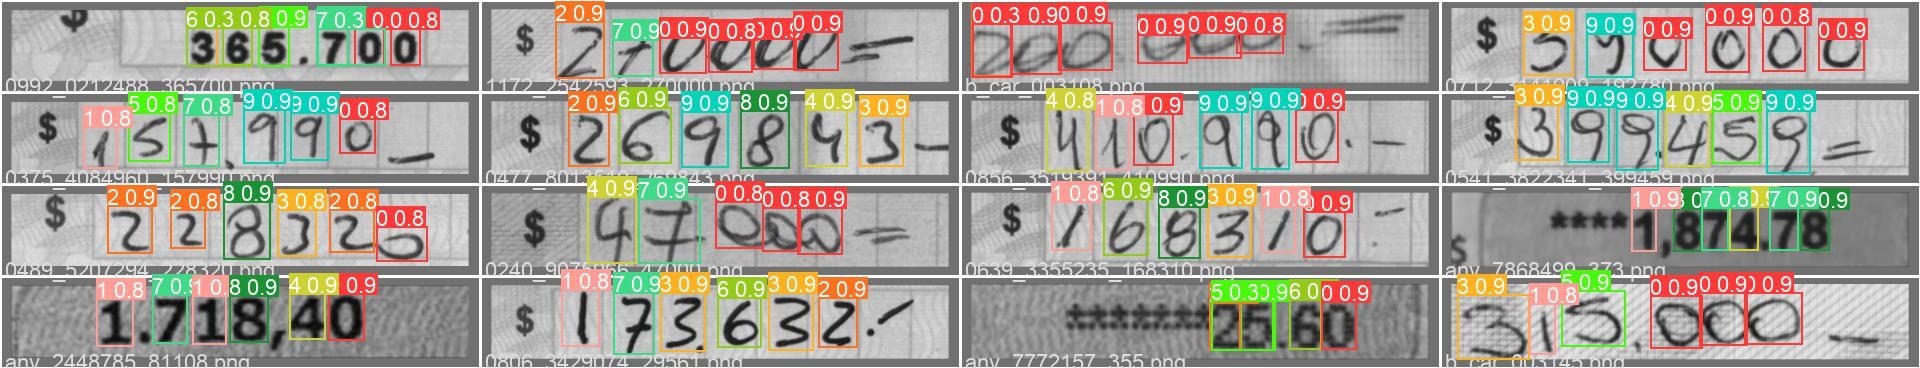

In [ ]:
from IPython.display import Image, display

display(Image('/content/yolov5/runs/train/exp/confusion_matrix.png'))
display(Image('/content/yolov5/runs/train/exp/results.png'))
display(Image('/content/yolov5/runs/train/exp/val_batch2_labels.jpg'))
display(Image('/content/yolov5/runs/train/exp/val_batch2_pred.jpg'))